XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Разберём задачу, в которой нужно предсказать доход человека (больше $50000 или меньше) по результатам переписи населения.
https://archive.ics.uci.edu/ml/datasets/Adult

Описание данных:
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик в бинарные значения
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
# удаляем строки с NA значениями
df = df.dropna()

test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

In [3]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Посчитаем распределение классов в отклике.

In [4]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Разбиваем выборку на обучающую и тестовую. 

In [5]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']



Бинаризуем категориальные признаки (эта операция ещё называется one-hot encoding).

In [6]:
X_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

После бинаризации категориальных признаков оказалось, что в обучающем множестве содержится на одну колонку больше. Причина: в тестовую выборку не попал ни один представитель Голландии (см. колонку native-county). Проверяем

In [7]:
print (len(X_train.columns))
print (len(X_test.columns))
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

88
87
{'native-country_ Holand-Netherlands'}
set()


Исправляем. 
Создадим полный список всех колонок (из трейна и из теста) и переиндексируем колонки в соответствии с этим списком. В результате в колонке native-country_ Holand-Netherlands в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [8]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0)
X_test = X_test.reindex(columns=columns).fillna(0)

Теперь колонки в обучающей и тестовой выборках должны быть идентичными. 
В том числе идентичным должен быть и порядок колонок. 
На всякий случай проверим.

In [9]:
# Команда all проверяет, все ли значения из входного списка равны True
all(X_train.columns == X_test.columns)

True

Перейдём, наконец, к обучению модели.
Хотя, если честно, можно многое улучшить.
Например, объединить некоторые колонки.

XGBoost

In [10]:
from sklearn.metrics import classification_report

# conda install py-xgboost
# conda install -c anaconda py-xgboost  -- появилась Teano
from xgboost import XGBClassifier

In [11]:
model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print (classification_report(y_train, y_pred_train))

y_pred = model.predict(X_test)
print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.95      0.93     22654
          1       0.84      0.73      0.78      7508

avg / total       0.90      0.90      0.90     30162

             precision    recall  f1-score   support

          0       0.90      0.94      0.92     11360
          1       0.77      0.66      0.71      3700

avg / total       0.86      0.87      0.87     15060



C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
import seaborn as sns
sns.set(font_scale = 1.5)

In [13]:
import xgboost as xgb


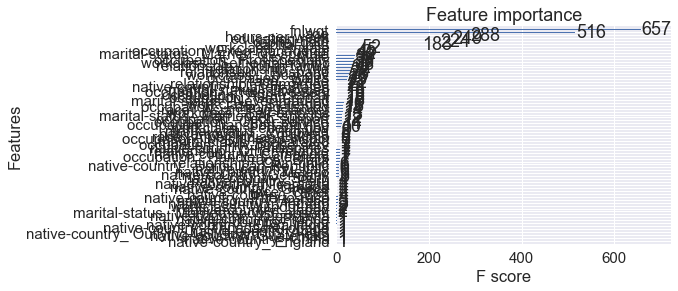

In [14]:
xgb.plot_importance(model)

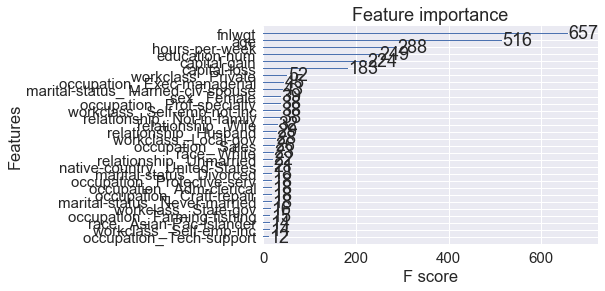

In [20]:
xgb.plot_importance(model, max_num_features = 30)

In [15]:
from sklearn.grid_search import GridSearchCV


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.05, 0.1, 0.3]
}

In [ ]:
#  model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)

In [17]:
zzz = GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, 
       colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)


In [20]:
zzz.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [21]:
sorted(zzz.cv_results_.keys())

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [24]:
zzz.grid_scores_

[mean: 0.86019, std: 0.00373, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86098, std: 0.00319, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86019, std: 0.00345, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86755, std: 0.00242, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.86811, std: 0.00275, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86732, std: 0.00304, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.86980, std: 0.00273, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.86831, std: 0.00234, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.86871, std: 0.00230, params: {'max_depth': 7, 'min_child_weight': 5}]